# Step.0 环境准备

1. Clone [https://github.com/iphysresearch/lfi-gw.git](https://github.com/iphysresearch/lfi-gw.git)
2. 根据 repo 中 readme 里所写安装 Setup：（或根据你的环境情况确保程序包都可用亦可）
  >Create and activate a conda environment with the correct software dependencies:
  >  ```shell
    conda env create -f environment.yml
    conda activate gwml
    ```
3. 打开 `./notebook` 文件夹中的本 jupyter notebook，按顺序执行 Step.1 -> Step.2 -> Step.3 (脚本)，即可。

---
# Step.1 下载数据信息


- Load Libs

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import urllib
import json
import h5py
from pathlib import Path

from scipy.signal import tukey

from gwpy.timeseries import TimeSeries
import pycbc.psd

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


- 选定一个 event，生成对应的数据集
  - O1 中有三个，O2 中有 7 个（GW170817 暂时不考虑）

In [2]:
## GWTC1

# O1
# event = 'GW150914'
# event = 'GW151012'
event = 'GW151226'

# O2
# event = 'GW170104'
# event = 'GW170608'
# event = 'GW170729'
# event = 'GW170809'
# event = 'GW170814'
## event = 'GW170817'  # 这个事件暂时忽略，不考虑
# event = 'GW170818'
# event = 'GW170823'

# 这部分代码会从网络上自动下载 JSON 数据

f = urllib.request.urlopen('https://www.gw-openscience.org/eventapi/json/allevents/')
allevents = json.loads(f.read())['events']

event_version = sorted([key for key, value in allevents.items() if event in key.split('-')[0]], 
                       key=lambda x: int(x.split('-')[-1][-1]), reverse=True)[0]
assert allevents[event_version]['commonName'] == event

# detectors
f = urllib.request.urlopen(allevents[event_version]['jsonurl'])
events_meta = json.loads(f.read())['events'][event_version]

detectors=sorted(list(set([meta['detector'] for meta in events_meta['strain']])))
print(detectors)

['H1', 'L1']


In [3]:
# events_meta#.keys()

In [4]:
# allevents[event_version]#.keys()

In [5]:
t_event = events_meta['GPS'] # GPS time of coalescence

T = 8.0  # number of seconds to analyze in a segment
T_psd = 1024.0  # number of seconds of data for estimating PSD
T_buffer = 2.0  # buffer time after the event to include

In [22]:
# 这部分代码会从网络上自动下载数据

i = -1 # -1 for original
while True: # 确保 PSD 数据中无异常值
    try: 

        h1_event = TimeSeries.fetch_open_data('H1', t_event + T_buffer - T, t_event + T_buffer, cache=True)
        l1_event = TimeSeries.fetch_open_data('L1', t_event + T_buffer - T, t_event + T_buffer, cache=True)

        # To calculate the PSD, take data before the event segment
        h1_psd = TimeSeries.fetch_open_data('H1', t_event + T_buffer - T+ i*T_psd, t_event + T_buffer - T + (i+1)*T_psd, cache=True)
        l1_psd = TimeSeries.fetch_open_data('L1', t_event + T_buffer - T+ i*T_psd, t_event + T_buffer - T + (i+1)*T_psd, cache=True)
        assert False == (True in np.isnan(h1_psd.value))
        assert False == (True in np.isnan(l1_psd.value))
        
        if len(detectors) == 3:
            v1_event = TimeSeries.fetch_open_data('V1', t_event + T_buffer - T, t_event + T_buffer, cache=True)
            v1_psd = TimeSeries.fetch_open_data('V1', t_event + T_buffer - T+ i*T_psd, t_event + T_buffer - T + (i+1)*T_psd, cache=True)        
            assert False == (True in np.isnan(v1_psd.value))
    except:
        i += 1
    else:
        break
    finally:
        print(i)

1
1


In [23]:
# Check sampling frequency
f_s = len(h1_event)/T
assert f_s == 4096

In [24]:
# Convert to pycbc TimeSeries objects.
h1_event = h1_event.to_pycbc()
l1_event = l1_event.to_pycbc()

h1_psd = h1_psd.to_pycbc()
l1_psd = l1_psd.to_pycbc()

if len(detectors) == 3:
    v1_event = v1_event.to_pycbc()
    v1_psd = v1_psd.to_pycbc()

In [25]:
# Window function
roll_off = 0.4
alpha = 2 * roll_off / T

w = tukey(int(T * f_s), alpha)

In [26]:
# PSD estimation
h1_psd = pycbc.psd.estimate.welch(h1_psd, seg_len=int(T * f_s), seg_stride=int(T * f_s), window=w, avg_method='median')
l1_psd = pycbc.psd.estimate.welch(l1_psd, seg_len=int(T * f_s), seg_stride=int(T * f_s), window=w, avg_method='median')
if len(detectors) == 3:
    v1_psd = pycbc.psd.estimate.welch(l1_psd, seg_len=int(T * f_s), seg_stride=int(T * f_s), window=w, avg_method='median')

In [33]:
psd_bayeswave_h1.shape

(8193,)

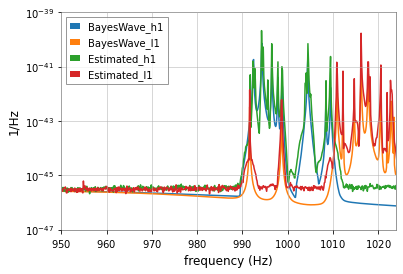

In [37]:
### For comparison to estimated PSD.
# I downloaded this data file from GWOSC
# https://dcc.ligo.org/LIGO-P1900011/public
psd_bayeswave = np.loadtxt('../data/psds/GWTC1_{}_PSDs.dat'.format(event))

# Add a final point at 1024 Hz
psd_bayeswave = np.append(psd_bayeswave, np.reshape(psd_bayeswave[-1], (1,3)), axis=0)
psd_bayeswave[-1,0] = 1024.0
psd_bayeswave_h1 = pycbc.psd.from_numpy_arrays(psd_bayeswave[:,0], psd_bayeswave[:,1], 8193, 1/8, 20.0)
psd_bayeswave_l1 = pycbc.psd.from_numpy_arrays(psd_bayeswave[:,0], psd_bayeswave[:,2], 8193, 1/8, 20.0)

#plt.figure(figsize=(15,11))
plt.plot(psd_bayeswave_h1.sample_frequencies, psd_bayeswave_h1, label='BayesWave_h1')
plt.plot(psd_bayeswave_l1.sample_frequencies, psd_bayeswave_l1, label='BayesWave_l1')
plt.plot(h1_psd.sample_frequencies, h1_psd, label='Estimated_h1')
plt.plot(l1_psd.sample_frequencies, l1_psd, label='Estimated_l1')
if len(detectors) == 3:
    psd_bayeswave_v1 = pycbc.psd.from_numpy_arrays(psd_bayeswave[:,0], psd_bayeswave[:,3], 8193, 1/8, 20.0)
    plt.plot(psd_bayeswave_v1.sample_frequencies, psd_bayeswave_v1, label='BayesWave_v1')
    plt.plot(v1_psd.sample_frequencies, v1_psd, label='Estimated_v1')
plt.yscale('log')
plt.xlim((950,1024))
plt.ylim((1e-47, 1e-39))
plt.legend()
plt.xlabel('frequency (Hz)')
plt.ylabel('1/Hz')
plt.show()

- 可以简单检查一下上图， Estimated PSDs 是不是和 BayesWave 有一个大致不错的拟合。

In [38]:
### Event
# Window the 8 s segment that contains the event, take the FFT, 
# and scale by the inverse ASD.
h1_event_FD = (h1_event * w).to_frequencyseries()
l1_event_FD = (l1_event * w).to_frequencyseries()

h1_event_FD_whitened = h1_event_FD / h1_psd ** 0.5
l1_event_FD_whitened = l1_event_FD / l1_psd ** 0.5

if len(detectors) == 3:
    v1_event_FD = (v1_event * w).to_frequencyseries()
    v1_event_FD_whitened = v1_event_FD / v1_psd ** 0.5

In [39]:
# Zero below 20 Hz and truncate above 1024 Hz. 
# This is all that is needed for the likelihood integral.

f_min = 20.0
f_max = 1024.0  # New f_max. Previously it was 2048 Hz.

h1_event_FD_whitened[:int(f_min / h1_event_FD_whitened.delta_f)] = 0.0
h1_event_FD_whitened = h1_event_FD_whitened[:int(f_max / h1_event_FD_whitened.delta_f)+1]

l1_event_FD_whitened[:int(f_min / l1_event_FD_whitened.delta_f)] = 0.0
l1_event_FD_whitened = l1_event_FD_whitened[:int(f_max / h1_event_FD_whitened.delta_f)+1]

# Apply a time shift to shift the merger to $t=0$. 
# This should make the event visible in the Fourier transform.
h1_event_FD_whitened = h1_event_FD_whitened.cyclic_time_shift(T_buffer)
l1_event_FD_whitened = l1_event_FD_whitened.cyclic_time_shift(T_buffer)

if len(detectors) == 3:
    v1_event_FD_whitened[:int(f_min / v1_event_FD_whitened.delta_f)] = 0.0
    v1_event_FD_whitened = v1_event_FD_whitened[:int(f_max / v1_event_FD_whitened.delta_f)+1]    
    v1_event_FD_whitened = v1_event_FD_whitened.cyclic_time_shift(T_buffer)

In [46]:
### Normalization

# The noise is not quite normalized to unit variance in the real and imaginary parts.

delta_f = h1_event_FD_whitened.delta_f

normalization_1 = 1 / np.sqrt(4 * delta_f)
window_factor = np.sum(w ** 2) / (T * f_s)

normalization = normalization_1 * np.sqrt(window_factor)
normalized_FD = h1_event_FD_whitened.numpy() / normalization
print(np.var(normalized_FD.real), np.var(normalized_FD.imag))

assert np.allclose(np.var(normalized_FD.real), 1, atol=0.1)
assert np.allclose(np.var(normalized_FD.imag), 1, atol=0.1)

1.0497358316751446 1.0601141909183767


In [ ]:
# Save PSD to file
event_dir = Path('../data/events/{}'.format(event))
event_dir.mkdir(parents=True, exist_ok=True)

h1_psd.save(event_dir / 'PSD_H1.txt')
l1_psd.save(event_dir / 'PSD_L1.txt')

if len(detectors) == 3:
    v1_psd.save(event_dir / 'PSD_V1.txt')

In [ ]:
# Save whitened FD strain data

with h5py.File(event_dir / 'strain_FD_whitened.hdf5', 'w') as f:
    f.create_dataset('sample_frequencies', data=np.array(h1_event_FD_whitened.sample_frequencies.numpy()))
    f.create_dataset('H1', data=h1_event_FD_whitened)
    f.create_dataset('L1', data=l1_event_FD_whitened)
    if len(detectors) == 3:
        f.create_dataset('V1', data=v1_event_FD_whitened)

In [ ]:
# Save additional information

with open(event_dir / 'event_info.json', 'w') as f:
    json.dump(dict(
        event=event,
        detectors=detectors,
        t_event=t_event,
        f_min=f_min,
        f_max=f_max,
        T=T,
        T_psd=T_psd,
        T_buffer=T_buffer,
        window_factor=window_factor,
        window='tukey',
        roll_off=roll_off
        ), f, indent=4)

---

# Step.2 生成 hdf5 训练数据

>注意：不要 restart kernel

<!--

for _, d in allevents.items():
    if (d['commonName'] in evs) and d['luminosity_distance']:
        print(d['commonName'])
        print('mass_1_source:', d['mass_1_source'],
              str(d['mass_1_source_lower']),
              '+'+str(d['mass_1_source_upper']),
             
             )       
        print('mass_2_source:', d['mass_2_source'],
              str(d['mass_2_source_lower']),
              '+'+str(d['mass_2_source_upper']))             
        print('chirp_mass_source:', d['chirp_mass_source'],
              str(d['chirp_mass_source_lower']),
              '+'+str(d['chirp_mass_source_upper']))
        print('luminosity_distance:', d['luminosity_distance'], 
              str(d['luminosity_distance_lower']),
              '+'+str(d['luminosity_distance_upper']),
             d['luminosity_distance_unit'])
        print()
-->
- Load lib

In [96]:
import os
os.chdir("..") # 改变工作目录到上一级
os.getcwd() # 查看当前工作目录

# ['GW150914', 'GW151012','GW151226', 'GW170104', 'GW170608', 'GW170729',
#  'GW170809', 'GW170814', 'GW170817', 'GW170818', 'GW170823']

'/root/gwspe'

In [92]:
# Refine the prior for each event
default_mass = [10.0, 80.0]
default_distance = [100.0, 1000.0]
Ref_prior = dict(
    GW150914={'mass_1':default_mass,        # 35.6 -3.1 +4.7
              'mass_2':default_mass,        # 30.6 -4.4 +3.0
              'distance':default_distance}, # 440.0 -170.0 +150.0
    GW151012={'mass_1':[5.0, 80.0],         # 23.2 -5.5 +14.9
              'mass_2':[5.0, 80.0],         # 13.6 -4.8 +4.1
              'distance':[100.0, 2000.0]},  # 1080.0 -490.0 +550.0
    GW151226={'mass_1':[3.0, 80.0],         # 13.7 -3.2 +8.8
              'mass_2':[3.0, 80.0],         # 7.7 -2.5 +2.2
              'distance':default_distance},  # 450.0 -190.0 +180.0
    GW170104={'mass_1':default_mass,         # 30.8 -5.6 +7.3
              'mass_2':default_mass,         # 20.0 -4.6 +4.9
              'distance':[100.0, 2000.0]},  # 990.0 -430.0 +440.0    
    GW170608={'mass_1':[3.0, 80.0],         # 11.0 -1.7 +5.5
              'mass_2':[3.0, 80.0],         # 7.6 -2.2 +1.4
              'distance':default_distance},  # 320.0 -110.0 +120.0
    GW170729={'mass_1':default_mass,         # 50.2 -10.2 +16.2
              'mass_2':default_mass,         # 34.0 -10.1 +9.1
              'distance':[1000.0, 5000.0]},  # 2840.0 -1360.0 +1400.0
    GW170809={'mass_1':default_mass,         # 35.0 -5.9 +8.3
              'mass_2':default_mass,         # 23.8 -5.2 +5.1
              'distance':[100.0, 2000.0]},  # 1030.0 -390.0 +320.0
    GW170814={'mass_1':default_mass,         # 30.6 -3.0 +5.6
              'mass_2':default_mass,         # 25.2 -4.0 +2.8
              'distance':default_distance},  # 600.0 -220.0 +150.0
#     GW170817={'mass_1':[0.1, 8.0],         # 1.46 -0.1 +0.12
#               'mass_2':[0.1, 8.0],         # 1.27 -0.09 +0.09
#               'distance':[10.0, 100.0]},  # 40.0 -15.0 +7.0
    GW170818={'mass_1':default_mass,         # 35.4 -4.7 +7.5
              'mass_2':default_mass,         # 26.7 -5.2 +4.3
              'distance':[100.0, 2000.0]},  # 1060.0 -380.0 +420.0
    GW170823={'mass_1':default_mass,         # 39.5 -6.7 +11.2
              'mass_2':default_mass,         # 29.0 -7.8 +6.7
              'distance':[100.0, 4000.0]},  # 1940.0 -900.0 +970.0
)

- 运行下面代码块

In [52]:
import lfigw.waveform_generator as wfg

wfd = wfg.WaveformDataset(spins_aligned=False, domain='RB',
                          extrinsic_at_train=True)

wfd.Nrb = 600
wfd.approximant = 'IMRPhenomPv2'

wfd.load_event('data/events/{}/'.format(event))

wfd.importance_sampling = 'uniform_distance'

wfd.prior['distance'] = Ref_prior[event]['distance']
wfd.prior['a_1'][1] = 0.88
wfd.prior['a_2'][1] = 0.88

wfd.prior['mass_1'] = Ref_prior[event]['mass_1']
wfd.prior['mass_2'] = Ref_prior[event]['mass_2']

print('Dataset properties')
print('Event', wfd.event)
print(wfd.prior)
print('f_min', wfd.f_min)
print('f_min_psd', wfd.f_min_psd)
print('f_max', wfd.f_max)
print('T', wfd.time_duration)
print('reference time', wfd.ref_time)

wfd.generate_reduced_basis(50000)

wfd.generate_dataset(1000000)

wfd.generate_noisy_test_data(5000)

wfd.save('waveforms/{}'.format(event))
wfd.save_train('waveforms/{}'.format(event))
wfd.save_noisy_test_data('waveforms/{}'.format(event))

print('Program complete. Waveform dataset has been saved.')

# Step.3 转化为 PCL 用的数据集

在最后的这一步，我其实是修改(阉割)了原 `lfigw/gwpe.py` 为 `lfigw/gwpe-dataset.py`，就是为了生成可以直接用来跑 PyTorch 模型的数据集合，所以在主目录中的终端里执行 `./PCL_dataset.sh` 即可。

>在终端中执行 `./PCL_dataset.sh` 之前，要记得修改该文件中的参数，里面只有 `data_dir`、 `model_dir` 和 `distance_prior` 需要根据对应的 `event` 数据集合路径和参数进行修改，其他参数都不十分重要。

例如：要跑 GW170104 的数据集，就修改为如下：（其中，`distance_prior` 的参数需要参考本 notebook 中 `Ref_prior` 所对应定义的 `distance` 参数）

```shell
python -m lfigw.gwpe-dataset train new nde \
    --data_dir waveforms/GW170104/ \
    --model_dir models/GW170104/ \
    --nbins 8 \
    --num_transform_blocks 10 \
    --nflows 15 \
    --batch_norm \
    --batch_size 16 \
    --lr 0.0002 \
    --epochs 500 \
    --distance_prior_fn uniform_distance \
    --distance_prior 100.0 2000.0 \
    --hidden_dims 512 \
    --truncate_basis 100 \
    --activation elu \
    --lr_anneal_method cosine
```

其会在主目录的 `PCL_GWML_demo/data/` 中生成对应 event 的训练和测试数据集。

In [107]:
event, Ref_prior[event]

('GW151226',
 {'mass_1': [3.0, 80.0], 'mass_2': [3.0, 80.0], 'distance': [100.0, 1000.0]})